In [1]:
import numpy as np

# Constants
TOLERANCE = 1.0e-6
CH_MAX = 0.1
CM_MAX = 0.1
NEWTON_END = 10
EPS = 0.98  # Emissivity

# Function: q_rh
def q_rh(rh, es, t):
    """
    Calculate specific humidity (q_rh) based on relative humidity (rh), saturation vapor pressure (es), and temperature (t).
    Adjusts rh if it's out of [0, 100] and adds check for temperature close to absolute zero.
    """
    # Ensure temperature is not below -273.15°C
    if t < -273.15:
        print("Warning: Temperature below absolute zero. Adjusting to -273.15.")
        return 0.0

    # Adjust rh to fit within [0, 100]
    rh = np.clip(rh, 0.0, 100.0)
    return 217.0 * es / (t + 273.15) * rh / 100.0

# Example Test for q_rh
print("Test q_rh:", q_rh(50, 20, 25))  # Expected: a positive float

# Subroutine: mos (Monin-Obukhov similarity theory)
def mos(B1, Z, Z0, UA, TA, TSF, RIB):
    """
    Calculate drag coefficient (CD) and heat transfer coefficient (CH) based on the Monin-Obukhov similarity theory.
    Iterates with Newton-Raphson method if RIB < 0.
    """
    if RIB <= -15.0:
        RIB = -15.0

    XXX = -1.0e-3 if RIB < 0 else 0.714
    for _ in range(NEWTON_END):
        if RIB < 0:
            # Newton-Raphson for unstable conditions
            XXX0 = XXX * Z0 / (Z + Z0)
            X = (1.0 - 16.0 * XXX)**0.25
            X0 = (1.0 - 16.0 * XXX0)**0.25
            PSIM = np.log((Z + Z0) / Z0) - np.log((X + 1)**2 * (X**2 + 1)) + 2 * np.arctan(X) - \
                   np.log((X + 1)**2 * (X0**2 + 1)) + 2 * np.arctan(X0)
            PSIH = PSIM + 0.4 * B1
            DPSIM = (1.0 - 16.0 * XXX)**-0.25 / XXX - (1.0 - 16.0 * XXX0)**-0.25 / XXX
            F = RIB * PSIM**2 / PSIH - XXX
            DF = RIB * (2 * DPSIM * PSIM * PSIH - (1.0 / np.sqrt(1.0 - 16.0 * XXX)) * PSIM**2) / PSIH**2 - 1
            XXXP = XXX
            XXX = XXX - F / DF
            if abs(XXX - XXXP) < TOLERANCE:
                break
        else:
            PSIM = np.log((Z + Z0) / Z0) + 7 * min(XXX, 0.714)
            PSIH = PSIM + 0.4 * B1
            break

    US = max(0.4 * UA / PSIM, 0.01)
    TS = 0.4 * (TA - TSF) / PSIH
    CD = US**2 / UA**2
    CH = 0.4 * US / PSIH / UA
    return CD, CH

# Example Test for mos
B1, Z, Z0, UA, TA, TSF, RIB = 0.1, 10.0, 0.1, 2.0, 20.0, 15.0, -1.0
print("Test mos:", mos(B1, Z, Z0, UA, TA, TSF, RIB))  # Expected: Two floats for CD and CH

# Subroutine: louis79_scheme
def louis79_scheme(rib, z_rib, z0):
    """
    Calculate exchange coefficients for heat (ch) and momentum (cm) based on the Richardson number (rib),
    roughness length (z0), and reference height (z_rib).
    """
    a2 = (0.4 / np.log(z_rib / z0))**2

    if rib >= 0:
        xx = 0.714 if rib >= 0.142857 else rib * np.log(z_rib / z0) / (1.0 - 7.0 * rib)
        ch = 0.16 / 0.74 / (np.log(z_rib / z0) + 7.0 * min(xx, 0.714))**2
        cm = ch  # Identical calculation in original code
    else:
        cmb = 7.4 * a2 * 9.4 * np.sqrt(z_rib / z0)
        chb = 5.3 * a2 * 9.4 * np.sqrt(z_rib / z0)
        ch = a2 / 0.74 * (1.0 - 9.4 * rib / (1.0 + chb * np.sqrt(-rib)))
        cm = a2 * (1.0 - 9.4 * rib / (1.0 + chb * np.sqrt(-rib)))

    # Apply max limit
    ch = min(ch, CH_MAX)
    cm = min(cm, CM_MAX)
    return ch, cm

# Example Test for louis79_scheme
rib, z_rib, z0 = -2.0, 10.0, 0.1
print("Test louis79_scheme:", louis79_scheme(rib, z_rib, z0))  # Expected: Two floats for ch and cm


Test q_rh: 7.27821566325675
Test mos: (0.0824820348860155, 0.08017931029178672)
Test louis79_scheme: (0.04054422089330514, 0.0300027234610458)


# 1-D heat 


In [2]:
import numpy as np

def heat_1d(dx, kw, tw, dt):
    """
    Solve the 1D heat conduction equation using an implicit finite-difference scheme.
    
    Parameters:
    - dx: numpy array of layer thicknesses (size nw)
    - kw: numpy array of thermal conductivities for each layer (size nw)
    - tw: numpy array of initial temperatures of each layer, modified in-place (size nw)
    - dt: time step for the heat conduction simulation
    
    Returns:
    - Updated temperature array tw, representing the new temperatures after one time step.
    """
    nw = len(dx)  # Number of layers
    a = np.zeros(nw)
    b = np.zeros(nw)
    c = np.zeros(nw)
    d = np.zeros(nw)
    gg = np.zeros(nw)
    ss = np.zeros(nw)

    # Set up the coefficients a, b, c, and the initial values in d
    for k in range(1, nw - 1):
        a[k] = -kw[k - 1] / (dx[k] * (dx[k] + dx[k + 1]) * 0.5) * dt
        c[k] = -kw[k] / (dx[k + 1] * (dx[k] + dx[k + 1]) * 0.5) * dt
        b[k] = 1.0 - a[k] - c[k]
        d[k] = tw[k]
    
    # Apply boundary conditions
    d[1] -= a[1] * tw[0]
    a[1] = 0.0
    d[nw - 2] -= c[nw - 2] * tw[nw - 1]
    c[nw - 2] = 0.0

    # Forward elimination in the Thomas algorithm
    gg[1] = b[1]
    ss[1] = d[1]
    
    for k in range(2, nw - 1):
        gg[k] = b[k] - a[k] * c[k - 1] / gg[k - 1]
        ss[k] = d[k] - a[k] * ss[k - 1] / gg[k - 1]

    # Back substitution
    tw[nw - 2] = ss[nw - 2] / gg[nw - 2]
    for k in range(nw - 3, 0, -1):
        tw[k] = (ss[k] - c[k] * tw[k + 1]) / gg[k]
    
    return tw


In [5]:
# Example parameters
dx = np.array([0.1] * 5)            # Thickness of each layer
kw = np.array([0.5] * 5)            # Thermal conductivity for each layer
tw = np.array([300, 310, 320, 330, 340], dtype=float)  # Initial temperatures
dt = 0.01                           # Time step

# Run the heat conduction model
updated_tw = heat_1d(dx, kw, tw, dt)
print("Updated temperatures:", updated_tw)


Updated temperatures: [300. 310. 320. 330. 340.]


0.03610000000000001


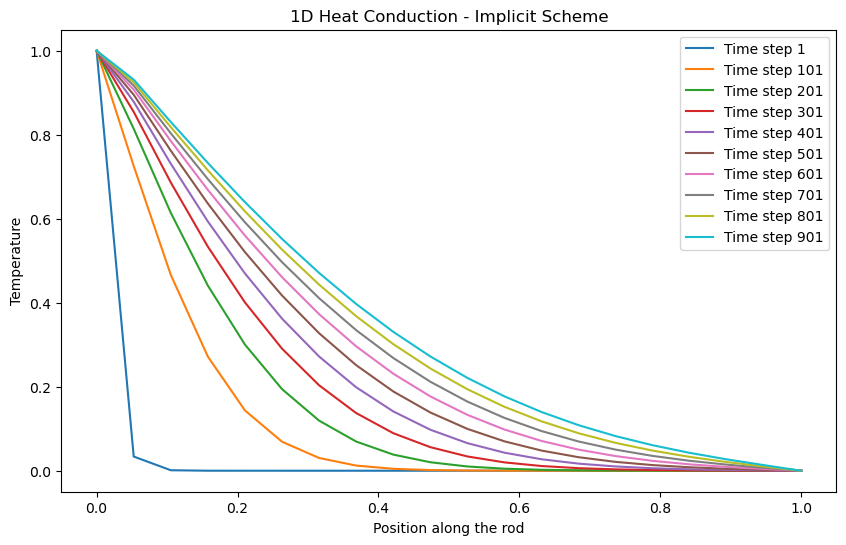

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0          # Length of the rod
T = 10          # Total time
Nx = 20          # Number of spatial points
Nt = 1000         # Number of time steps
alpha = 0.01     # Thermal diffusivity
dx = L / (Nx - 1)  # Spatial step
dt = T / Nt       # Time step
s = alpha * dt / dx**2

print(s)

# Stability criterion for implicit methods is not as strict, but we ensure dt is small enough
assert s <= 0.5, "Choose smaller dt or dx for numerical stability."

# Initial condition: u(x, 0) = 0
u = np.zeros(Nx)

# Boundary conditions: u(0, t) = 1, u(L, t) = 0
u[0] = 1
u[-1] = 0

# Coefficient matrix
A = np.zeros((Nx, Nx))
np.fill_diagonal(A, 1 + 2 * s)
np.fill_diagonal(A[1:], -s)
np.fill_diagonal(A[:, 1:], -s)
A[0, 0] = A[-1, -1] = 1  # Enforce boundary conditions

# Set up plot
x = np.linspace(0, L, Nx)
num_plots = 10
plot_interval = Nt // num_plots

plt.figure(figsize=(10, 6))
for n in range(Nt):
    # Update the temperature distribution at the next time step
    u = np.linalg.solve(A, u)
    # Enforce boundary conditions at each time step
    u[0] = 1
    u[-1] = 0
    
    # Plot only at intervals
    if n % plot_interval == 0:
        plt.plot(x, u, label=f"Time step {n+1}")

# Finalize plot
plt.xlabel("Position along the rod")
plt.ylabel("Temperature")
plt.title("1D Heat Conduction - Implicit Scheme")
plt.legend()
plt.show()
